# ROMS Tutorial 2: simple plotting commands

by David Gwyther

This tutorial will focus on quick and simple plots of ROMS output using xarray

In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/tmp'

## load data

In [11]:
# load single ROMS netcdf with xr
ds = xr.open_dataset('../data/raw/outer_his_08005.nc')
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                    eta_psi: 316, xi_psi: 271, ocean_time: 31)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2011-12-07
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/90)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux         (ocean_time, eta_rho, xi_rho) float32 ...
    sustr          (ocean_time, eta_u, xi_u) float32 ...
    svstr          (ocean_time, eta_v, xi_v) float32 ...
    bustr          (ocean_time, eta_u, xi_u) float32 ...
    bvstr          (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## let's first process our dataset and make a grid file

In [14]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

ds = processROMSGrid(ds)

grid = makeROMSGridObject(ds)

In [4]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 31)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho        (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.15 -28.16
    lon_u          (eta_rho, xi_u) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    ...             ...
    lon_psi        (eta_v, xi_u) float64 ...
    lat_psi        (eta_v, xi_u) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-06 ... 1990-01-01
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 0.0
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 ... -1.521
    z_rho0         (eta_rho, xi_rho, s_rho) float64 -32.9 -31.0 ... -1.221
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/113)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 1.521
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 0.0 0.0 ... 3.177
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 0.0 0.0 ... 1.521
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 0.0 0.0 ... 3.177
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 0.0 0.0 ... 1.521
    dA             (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## plot some surface values

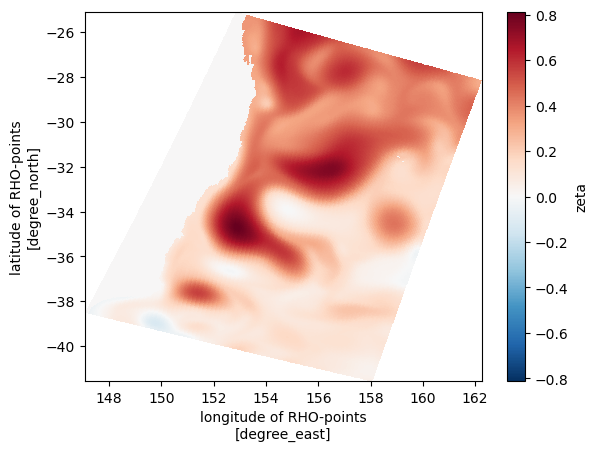

In [5]:
ds.zeta.mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho')

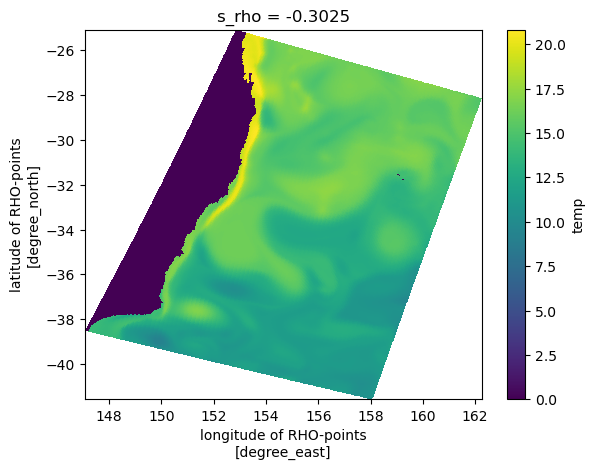

In [6]:
ds.temp.mean(dim='ocean_time').isel(s_rho=15).plot(x='lon_rho',y='lat_rho')

/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


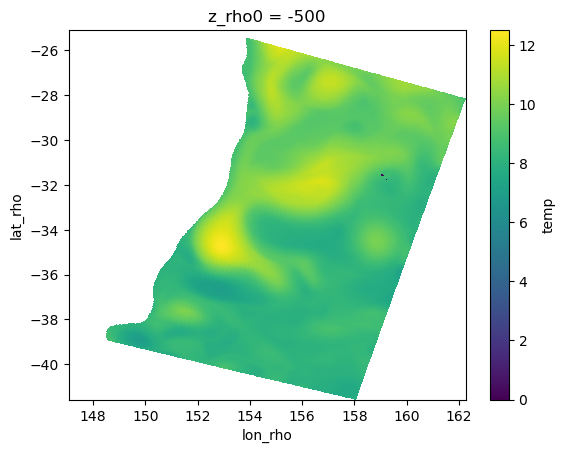

In [7]:

temp500 = grid.transform(ds.temp.mean(dim='ocean_time'), 'Z', np.array([-500]),target_data=ds.z_rho0,method='linear').squeeze()


temp500.plot(x='lon_rho',y='lat_rho')

In [10]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                    xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 31)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho        (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.15 -28.16
    lon_u          (eta_rho, xi_u) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    ...             ...
    lon_psi        (eta_v, xi_u) float64 ...
    lat_psi        (eta_v, xi_u) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-06 ... 1990-01-01
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 0.0
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 ... -1.521
    z_rho0         (eta_rho, xi_rho, s_rho) float64 -32.9 -31.0 ... -1.221
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/113)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 1.521
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 0.0 0.0 ... 3.177
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 0.0 0.0 ... 1.521
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 0.0 0.0 ... 3.177
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 0.0 0.0 ... 1.521
    dA             (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## Now some vertical transects


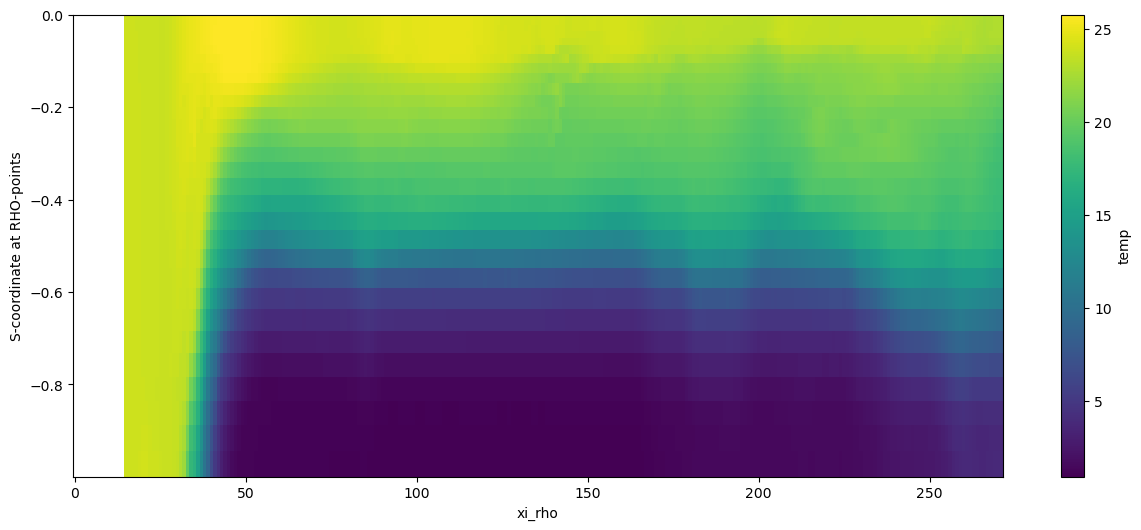

In [12]:
# this is what a naive plot of a x vs depth looks like with ROMS data - the perils of a s-coordinate
ds.temp.isel(eta_rho=316).sel(ocean_time=slice('2011-12-07','2011-12-08')).mean(dim='ocean_time').plot(figsize=(15,6))

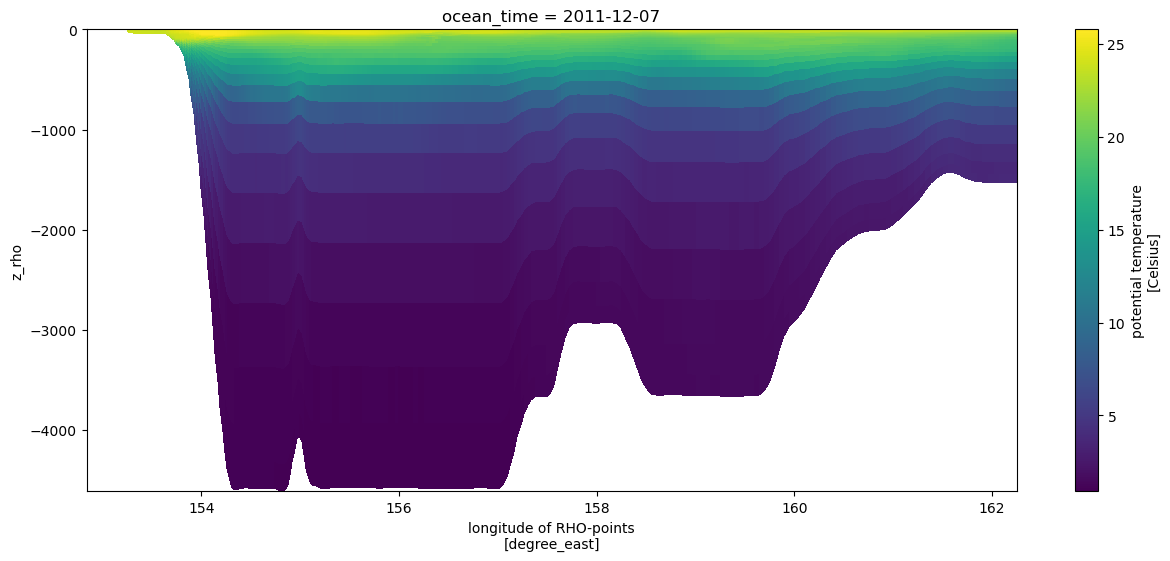

In [15]:
# so let's instead plot against the depth coordinate we made
ds.temp.isel(eta_rho=316,ocean_time=-1).plot(x='lon_rho',y='z_rho',figsize=(15,6))
